In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.datasets import load_wine

def read_data(dir_path, start, end):
    df = pd.read_csv(dir_path)
    features = np.array(df.columns)[start:end]
    data = df.to_numpy()
    return data, features

customer_data_path = "./SMAI-Dataset-customer-dataset/data.csv"
data, features = read_data(customer_data_path, 1, 8)

scaler = StandardScaler()
X = scaler.fit_transform(data[:, 1:8])

class GMM():
    def __init__(self, n_components, tol=1e-3, cov_reg=1e-8, max_iter=100, seed=0):
        self.n_components = n_components
        self.tol = tol
        self.cov_reg = cov_reg
        self.max_iter = max_iter
        self.no_of_iter = 0
        self.prev_log_likelihood = 0
        self.log_likelihood = 0
        self.seed = seed

    def likelihood_function(self, X):
        N = X.shape[0]
        get_component_prob = lambda x: self.component_pdfs(x)
        prior_probs = np.apply_along_axis(arr=X, func1d=get_component_prob, axis=1)
        
        taus_rep = np.tile(self.taus, reps=(N, 1)) 
        ans = np.sum(prior_probs*taus_rep, axis=1)
        #ans += cov_reg
        return np.sum(np.log(ans), axis=0) #log-likelihood value
    
    def component_pdfs(self, x):
        return np.array([multivariate_normal.pdf(x, self.mus[k], (self.sigmas[k] + np.eye(self.sigmas[k].shape[0])*self.cov_reg)) 
                        for k in range(self.n_components)])

    def e_step(self, X):
        K, N = self.mus.shape[0], X.shape[0] 
        get_component_prob = lambda x: self.component_pdfs(x)
        posterior = np.apply_along_axis(arr=X, func1d=get_component_prob, axis=1) 
        
        taus_rep = np.tile(self.taus, reps=(N, 1)) 

        norm_const = np.sum(posterior*taus_rep, axis=1) 
        norm_const_rep = np.tile(norm_const, reps=(K, 1)).T 
        #norm_const_rep += cov_reg
        posterior = posterior*taus_rep/norm_const_rep 
        return posterior.T
    
    def m_step(self, X, T):
        N, n = X.shape
        def get_sigma(X, muk, Tk):
            X_centred = X - muk
            X_weighted = X_centred * np.tile(Tk, reps=(X.shape[1],1)).T 
            sigmak =  X_weighted.T@X_centred/np.sum(Tk) 
            return sigmak

        K = T.shape[0]
        T_sum = np.sum(T, axis=1)

        self.taus = T_sum / N

        T_sum_rep = np.tile(T_sum, reps=(n, 1)).T 
        self.mus = T@X/T_sum_rep 
        self.sigmas = np.array([get_sigma(X, self.mus[k, :], T[k, :]) for k in range(K)])

    def fit(self, X):

        def initalize_params(X):
            N, n = X.shape
            np.random.seed(self.seed)
            weights_ = np.ones(self.n_components)/self.n_components
            means_ = np.array(X[np.random.choice(np.arange(0, N), self.n_components, replace=False)])
            covariances_ = [np.eye(n) for _ in range(self.n_components)]
            self.mus, self.sigmas, self.taus = means_, covariances_, weights_
        
        initalize_params(X)

        self.prev_log_likelihood = self.likelihood_function(X)
        for i in range(self.max_iter):
            T = self.e_step(X)
            self.m_step(X, T)
            self.log_likelihood = self.likelihood_function(X)
            self.no_of_iter += 1
            if(abs(self.log_likelihood - self.prev_log_likelihood) < self.tol):
                break
            self.prev_log_likelihood = self.log_likelihood

    def get_params(self):
        return self.mus, self.sigmas, self.taus

    def compute_bic(self, X):
        K = self.n_components
        N, n = X.shape
        cov_params = K * n * (n + 1) / 2.0
        mean_params = n * K
        n_parameters = int(cov_params + mean_params + K - 1)
        bic = (-2*self.likelihood_function(X)) + (n_parameters * np.log(N))
        return bic
    
    def compute_aic(self, X):
        K = self.n_components
        N, n = X.shape
        cov_params = K * n * (n + 1) / 2.0
        mean_params = n * K
        n_parameters = int(cov_params + mean_params + K - 1)
        aic = (-2*self.likelihood_function(X)) + (2 * n_parameters)
        return aic

    def predict(self, X):
        T = self.e_step(X)
        return np.argmax(T.T, axis=1)

def best_clusterCount(X):
    num_clusters_range = range(3, 11)
    aic_scores = np.array([])
    bic_scores = np.array([])
    for num_clusters in num_clusters_range:
        gmm = GMM(n_components=num_clusters, tol=1e-3, cov_reg=1e-8, max_iter=100)
        gmm.fit(X)
        aic_scores = np.append(aic_scores, gmm.compute_aic(X))
        bic_scores = np.append(bic_scores, gmm.compute_bic(X))
    
    optimal_num_clusters_bic = num_clusters_range[np.argmin(bic_scores)]
    optimal_num_clusters_aic = num_clusters_range[np.argmin(aic_scores)]

    return optimal_num_clusters_bic, optimal_num_clusters_aic
    

def vary_clusters(X):
    num_clusters_range = range(3, 11)
    for num_clusters in num_clusters_range:
        gmm = GMM(n_components=num_clusters, tol=1e-3, cov_reg=1e-8, max_iter=100)
        gmm.fit(X)
        print("No.of Iterations: ", gmm.no_of_iter, "Log-Likelihood: ", gmm.log_likelihood)
        print("*******Weights************")
        print(gmm.taus)
        print("*******Means************")
        print(gmm.mus)
        print("*******Covariance************")
        print(gmm.sigmas)
        break
for num_clusters in range(3, 11):
        gmm = GMM(n_components=num_clusters, tol=1e-3, cov_reg=1e-8, max_iter=100)
        gmm.fit(X)
        print("No.of Iterations: ", gmm.no_of_iter, "Log-Likelihood: ", gmm.log_likelihood)
#optimal_num_clusters_bic, optimal_num_clusters_aic = best_clusterCount(X)
#print("Optimal number of clusters using BIC: ", optimal_num_clusters_bic)
#print("Optimal number of clusters using AIC: ", optimal_num_clusters_aic) 



No.of Iterations:  12 Log-Likelihood:  4801.010960720288
No.of Iterations:  55 Log-Likelihood:  2664.107398614547
No.of Iterations:  28 Log-Likelihood:  13582.882962847361
No.of Iterations:  57 Log-Likelihood:  19839.31647471858
No.of Iterations:  13 Log-Likelihood:  22089.47283623409
No.of Iterations:  13 Log-Likelihood:  23116.80666350898
No.of Iterations:  12 Log-Likelihood:  25273.962159183055
No.of Iterations:  42 Log-Likelihood:  27079.07694305413


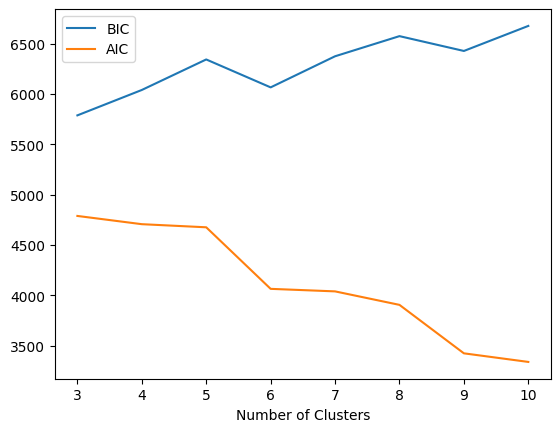

Optimal number of clusters based on BIC: 3
Predicted labels using the optimal number of clusters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 0 0 1 2 2 0
 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal number of clusters based on AIC: 10
Predicted labels using the optimal number of clusters: [0 0 3 3 6 3 6 6 0 0 3 0 6 3 3 6 6 6 6 0 0 6 6 6 6 5 0 0 6 0 3 3 0 6 6 3 6
 6 0 0 0 4 0 4 0 6 0 0 0 3 3 6 0 6 0 3 0 6 0 8 9 9 8 2 9 8 2 8 9 0 9 2 8 3
 2 9 8 9 3 4 8 8 9 9 8 8 9 9 9 9 9 9 9 2 2 3 3 2 2 2 8 8 8 8 8 9 8 9 8 2 4
 8 9 8 8 9 8 8 9 8 2 5 4 4 4 8 8 9 8 4 1 1 1 1 9 7 7 7 7 7 7 7 7 7 1 7 7 7
 7 1 1 1 1 7 7 7 7 7 1 1 7 7 7 7 7 7 1 1 1 1 7 7 7 7 7 1 1 7]


In [9]:
from sklearn.cluster import KMeans
wine = load_wine()["data"]
original_classes = load_wine()["target"]

scaler = StandardScaler()
wine_data = scaler.fit_transform(wine)
N = wine_data.shape[0]
n = wine_data.shape[1]
bic_values = np.array([])
aic_values = np.array([])

num_clusters_range = range(3, 11)

kmeans = KMeans(n_clusters=3, n_init=10)

kmeans.fit(wine_data)

for num_clusters in num_clusters_range:
    gmm = GMM(n_components=num_clusters, tol=1e-3, cov_reg=1e-8, max_iter=100)
    gmm.fit(wine_data)
    bic_values = np.append(bic_values, np.array(gmm.compute_bic(wine_data)))
    aic_values = np.append(aic_values, np.array(gmm.compute_aic(wine_data)))


values = np.array([bic_values, aic_values])
labels = np.array(["BIC", "AIC"])
for i in range(2):
    plt.plot(num_clusters_range, values[i], label=labels[i])

plt.xlabel("Number of Clusters")
plt.legend()
plt.show()

optimal_num_clusters_bic = num_clusters_range[np.argmin(bic_values)]
optimal_num_clusters_aic = num_clusters_range[np.argmin(aic_values)]

gmm_optimal_bic = GMM(n_components=optimal_num_clusters_bic, tol=1e-3, cov_reg=1e-8, max_iter=100) 
gmm_optimal_bic.fit(wine_data)
predicted_labels_bic = gmm_optimal_bic.predict(wine_data)

print("Optimal number of clusters based on BIC:", optimal_num_clusters_bic)
print("Predicted labels using the optimal number of clusters:", predicted_labels_bic)

gmm_optimal_aic = GMM(n_components=optimal_num_clusters_aic, tol=1e-3, cov_reg=1e-8, max_iter=100)
gmm_optimal_aic.fit(wine_data)
predicted_labels_aic = gmm_optimal_aic.predict(wine_data)

print("Optimal number of clusters based on AIC:", optimal_num_clusters_aic)
print("Predicted labels using the optimal number of clusters:", predicted_labels_aic)


### 2.1.2 Observations:
<ol>
<li>Optimal Number of Clusters using <b>BIC</b> is 3 because the lowest value is occuring when number of clusters equals 3</li>
<br>
<li>Optimal Number of Clusters using <b>AIC</b> is 10 because the lowest value is occuring when number of clusters equals 3</li>
<br>
<li>Based on above graphs, having 3 clusters is the best choice for this dataset. As we increase the number of clusters, the model becomes overly complex (indicated by rising BIC) and less efficient (indicated by declining AIC), leading to the conclusion that 3 clusters is optimal for this dataset.</li>
</ol>

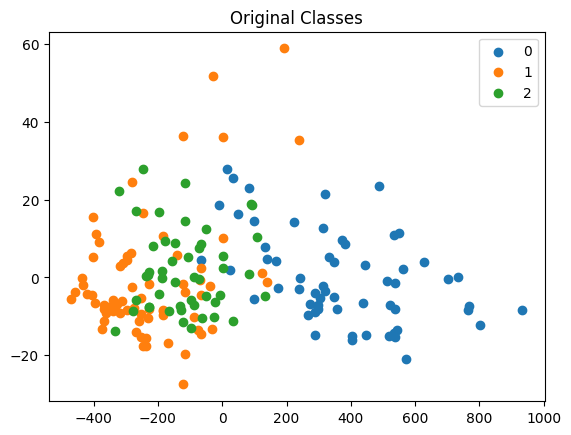

Silhouette Score for KMeans:  0.5722554756855063


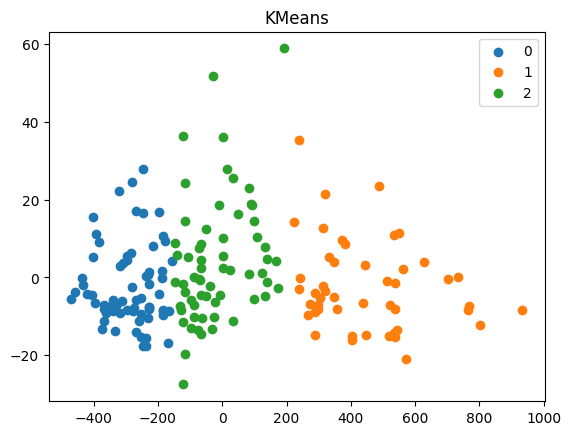

Silhouette Score for GMM:  0.4327113795510764


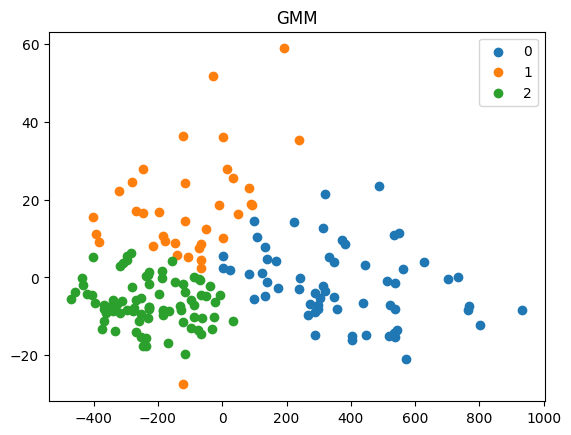

In [10]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def ScatterPlot(X, predicted_classes, title):
    unique_labels = np.unique(predicted_classes)
    for label in unique_labels:
        plt.scatter(X[predicted_classes == label, 0], X[predicted_classes == label, 1], label=label)
    plt.title(title)
    plt.legend()
    plt.show()

pca = PCA(n_components=2)
pca.fit(wine)
x = pca.transform(wine)
ScatterPlot(x, original_classes, 'Original Classes')

km = KMeans(n_clusters=3, n_init=10)
km.fit(x)
km_silscore = silhouette_score(x, km.labels_, metric='euclidean')
print("Silhouette Score for KMeans: ", km_silscore)
ScatterPlot(x, km.labels_, 'KMeans')

x_standard = scaler.fit_transform(x)
gmm = GMM(n_components=3, tol=1e-3, cov_reg=1e-8, max_iter=100)
gmm.fit(x_standard)
gmm_predlabels = gmm.predict(x_standard)
gmm_silscore = silhouette_score(x_standard, gmm_predlabels, metric='euclidean')
print("Silhouette Score for GMM: ", gmm_silscore)
ScatterPlot(x, gmm_predlabels, 'GMM')

### 2.1.2 Observations: 
<ol>
<li><b>K-Means:</b>In the scatter plot of K-means, we can observe that the clusters are somewhat spherical and have roughly equal sizes. K-Means is sensitive to initialization of cluster centers and also if the data itself naturally forms different shapes and orientations, then K-means wouldn't be able to capture the patterns of clustering properly.</li>
<br>
<li><b>GMM:</b>The clusters in the scatter plot of GMM appear more elliptical and could capture inner structure within the data. GMM can handle clusters with different sizes and orientations, making it more suitable to complex datasets.</li>
<br>
<li>From the above plots, we can conclude that GMM has outperformed K-Means. This indicates that the wine dataset naturally forms clusters with different shapes and orientations. That's the reason why the performance of K-means is far less accurate than that of GMM</li>
</ol>

<ol>
<li><b>Silhouette Score of K-means: </b>A Silhouette Score of 0.572 is relatively high, suggesting that the data points within each cluster are tightly grouped and well-separated from other clusters.</li>
<br>
<li><b>Silhouette Score of GMM: </b>A Silhouette Score of 0.433 is lower compared to K-Means, implying that the clusters generated by GMM may have some degree of overlap between neighboring clusters.</li>
<br>
<li>It's important to consider the specific characteristics of your data and your clustering objectives. GMM's flexibility in modeling complex data distributions may still make it a suitable choice in certain situations, even if its Silhouette Score is slightly lower than K-Means.</li>
</ol>